# Gini

In [19]:
import numpy as np
from numba import jit
import pandas as pd

In [20]:
@jit
def gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n - 1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# What is the Gini?

The Gini coefficient is a measure of inequality that can be calculated using the following steps

Rank the values of the variable being measured in ascending order.
Calculate the cumulative relative frequency of each value, which is the proportion of observations with values less than or equal to that value.
Calculate the Lorenz curve, which plots the cumulative relative frequency on the y-axis and the rank of the values on the x-axis.
Calculate the Gini coefficient by dividing the area between the Lorenz curve and the line of perfect equality (where the cumulative relative frequency is equal to the rank of the values) by the total area under the line of perfect equality.

We use the gini coefficient since we are relating the problem back to insurance - Gini is a vital metric in insurance because we care more about segregating high and low risks than predicting losses. A higher gini is going to mean our model is better able to tell between high risk and low risk cases.

In our analysis, precision and accuracy will not be good for evaluating performance. Where we have a large class imbalance with many more 0's than 1's, a model would be able to score highly by simply predicting 0's. The gini score cares about the orders our predictions to avoid this issue.

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

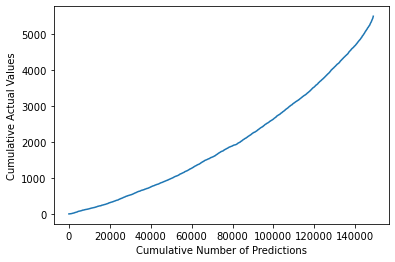

In [22]:
boosting_preds = pd.read_csv("Results/lgbm_bayesian_opt.csv")['target'].values
targets = pd.read_csv("Dataset/target_test.csv")['target'].values

data = zip(targets, boosting_preds)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]

# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

plt.plot(cumulative_index, cumulative_actual)
plt.xlabel('Cumulative Number of Predictions')
plt.ylabel('Cumulative Actual Values')
plt.show()

This corresponds to the Lorenz Curve.

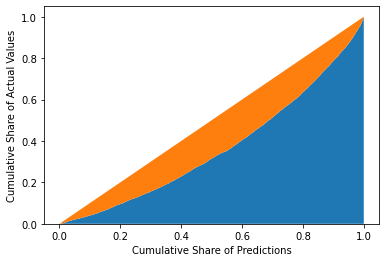

In [23]:
cumulative_actual_shares = cumulative_actual / sum(targets)
cumulative_index_shares = cumulative_index / len(boosting_preds)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_shares)
y_values = [0] + list(cumulative_actual_shares)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()




Our gini coefficient is then calculated by taking the orange area. (the triangle minus the area under the Lorenz Curve

If we were to randomly guess, our gini coefficient would be 0

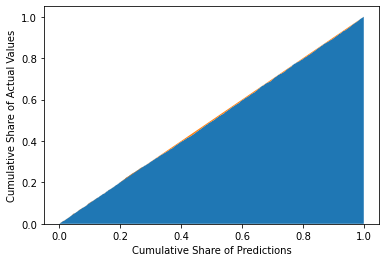

In [24]:
import random
guess = []
for i in range(len(targets)):
    randomint = random.randint(0, 1)
    guess.append(randomint)

data = zip(targets, guess)
sorted_data = sorted(data, key=lambda d: d[1])
sorted_actual = [d[0] for d in sorted_data]

# Sum up the actual values
cumulative_actual = np.cumsum(sorted_actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1)

cumulative_actual_shares = cumulative_actual / sum(targets)
cumulative_index_shares = cumulative_index / len(guess)

# Add (0, 0) to the plot
x_values = [0] + list(cumulative_index_shares)
y_values = [0] + list(cumulative_actual_shares)

# Display the 45° line stacked on top of the y values
diagonal = [x - y for (x, y) in zip(x_values, y_values)]

plt.stackplot(x_values, y_values, diagonal)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.show()

# Comparison of Gini Scores from our model

In [25]:
baseline = pd.read_csv("Results/baseline_preds.csv")['predictions']
knn = pd.read_csv("Results/knns.csv")['1']
lasso = pd.read_csv("Results/lasso_preds.csv")['s0']
lightgbm_bay = pd.read_csv("Results/lgbm_bayesian_opt.csv")['target']
targets = pd.read_csv("Dataset/target_test")['target']

models = ['Baseline', 'LASSO', 'KNN', 'LightGBM']
preds = [baseline, lasso, knn, lightgbm_bay]
gini_scores = []
j = 0
for i in preds:
    gini_scores.append(gini(targets, i))
    print(models[j], gini_scores[j])
    j+=1

<ipython-input-20-47cba55a5939>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gini" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-20-47cba55a5939> (3)

File "<ipython-input-20-47cba55a5939>", line 3:
def gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    ^

  @jit
<ipython-input-20-47cba55a5939>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "gini" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-20-47cba55a5939>", line 9:
def gini(y_true, y_prob):
    <source elided>
    n = len(y_true)
    for i in range(n - 1, -1, -1):
    ^

  @jit
C:\Users\thoma\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "gini" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-in

Baseline 0.25490761823729324
LASSO 0.2556699128124136
KNN 0.11599799913885367
LightGBM 0.2817052971888222


# Comparison between mean imputation and regression imputation

We run our highest performing model with mean imputed data

In [26]:
lightgbm_bay = pd.read_csv("Results/MeanImpute/lgbm.csv")['target']
targets = pd.read_csv("Dataset/target_test")['target']

models = ['LightGBM mean imputed']
preds = [lightgbm_bay]
gini_scores = []
j = 0
for i in preds:
    gini_scores.append(gini(targets, i))
    print(models[j], gini_scores[j])
    j+=1
print('LightGBM regression imputed 0.2817052971888222')

LightGBM mean imputed 0.28120416315397734
LightGBM regression imputed 0.2817052971888222


The difference isn't as great as we thought it might be with only a slight improvement for the regression imputed data. It could be that these features we have imputed are not very important for predicting the target. The greatest difference in performance came from optimising the hyper-parameters.